In [21]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
%matplotlib inline
plt.rcParams.update({'font.size': 16})
colors = ['lightblue', 'pink']
feature_keys = ['total words','total uniq', 'total wpt','D uniq','D words',\
                'D wpt','D pos_avg','P uniq','P words','P wpt','P pos_avg']
outcome = ['discDmind3','cumulative rating']
df_phase1  = pd.read_csv('phase1_lect_ata_new_df.csv')
df_phase2  = pd.read_csv('phase2_lect_ata_new_df.csv')
df = pd.concat([df_phase1,df_phase2])

df_sent  = pd.read_csv('all_w_sent.csv',encoding = "ISO-8859-1")
df_liwc  = pd.read_csv('all_w_liwc.csv',encoding = "ISO-8859-1")
liwc_features = df_liwc.keys()[3:].tolist()
liwc_features = ['Achievement','Affective','Anger','Anxiety','Biological','Body','Causation','Certainty','Cognitive',\
                 'Discrepancy','Family','Feeling','Fillers','Friends','Future tense','Health','Hearing','Home',\
                 'Humans','Insight','Leisure','Money','Negative Emotion','Positive emotion','Religion','Sadness',\
                 'Sexual','Social','Swear','Time','death@Death']

#df_liwc = df_liwc.groupby(['Filename']).mean()
#df_sent = df_sent.groupby(['Filename']).mean()
def get_male_female_files(p_male,d_male):
	phase1_files = df_phase1[(df_phase1['isPatientMale']==p_male)&(df_phase1['isDoctorMale']==d_male)]['Filename'].tolist()
	phase2_files = df_phase2[(df_phase2['isPatientMale']==p_male)&(df_phase2['isDoctorMale']==d_male)]['Filename'].tolist()
	return phase1_files+phase2_files

male_doctor_file_names = get_male_female_files(0,1)+ get_male_female_files(1,1)
female_doctor_file_names = get_male_female_files(0,0)+ get_male_female_files(1,0)
male_patient_file_names = get_male_female_files(1,0)+ get_male_female_files(1,1)
female_patient_file_names = get_male_female_files(0,0)+ get_male_female_files(0,1)

maleD_femaleP_file_names = get_male_female_files(0,1)
maleD_maleP_file_names = get_male_female_files(1,1)
femaleD_femaleP_file_names = get_male_female_files(0,0)
femaleD_maleP_file_names = get_male_female_files(1,0)

<h2>Male-Female Doctor regression on LIWC for Doscordance</h2>

In [15]:
from sklearn.linear_model import Lasso
XY = df[df['Filename'].isin(male_doctor_file_names)][['Filename']+outcome].dropna()
liwc = df_liwc[df_liwc['Filename'].isin(male_doctor_file_names)]
XY = pd.merge(XY,liwc,how='inner',on = 'Filename')
XY = XY.groupby('Filename').mean()
X = XY[liwc_features]
X = scale(X)
Y = XY['discDmind3']
best_err = np.inf
best_alpha = 0
for a in np.arange(0.1,1,0.1):
    clf = Lasso(alpha = a).fit(X,Y)
    ans = clf.predict(X)
    err = mean_squared_error(ans,Y)
    if(err < best_err):
        best_alpha = a
        best_err = err
        male_Ddiscordance_coefs = clf.coef_
print('Best Error = ', best_err, 'alpha = ', best_alpha,male_Ddiscordance_coefs)

XY = df[df['Filename'].isin(female_doctor_file_names)][['Filename']+outcome].dropna()
liwc = df_liwc[df_liwc['Filename'].isin(female_doctor_file_names)]
XY = pd.merge(XY,liwc,how='inner',on = 'Filename')
XY = XY.groupby('Filename').mean()
X = XY[liwc_features]
X = scale(X)
Y = XY['discDmind3']
best_err = np.inf
best_alpha = 0
for a in np.arange(0.1,1,0.1):
    clf = Lasso(alpha = a).fit(X,Y)
    ans = clf.predict(X)
    err = mean_squared_error(ans,Y)
    if(err < best_err):
        best_alpha = a
        best_err = err
        female_Ddiscordance_coefs = clf.coef_
print('Best Error = ', best_err, 'alpha = ', best_alpha,female_Ddiscordance_coefs)

Best Error =  3.310537967385727 alpha =  0.1 [-0.          0.         -0.          0.          0.          0.
  0.          0.         -0.          0.          0.04510266  0.
  0.          0.         -0.          0.          0.01360184  0.
  0.         -0.         -0.06777262  0.         -0.          0.00601478
  0.09469143 -0.00386591 -0.          0.         -0.07740009 -0.00778493
  0.23015665]
Best Error =  2.873068863597236 alpha =  0.1 [ 0.12691143 -0.          0.         -0.         -0.          0.01879359
 -0.          0.          0.         -0.          0.          0.
 -0.          0.05565788 -0.16660034 -0.          0.          0.
 -0.0048725   0.24378385 -0.02066229 -0.         -0.         -0.
 -0.          0.          0.04752872  0.          0.19662191 -0.
 -0.        ]


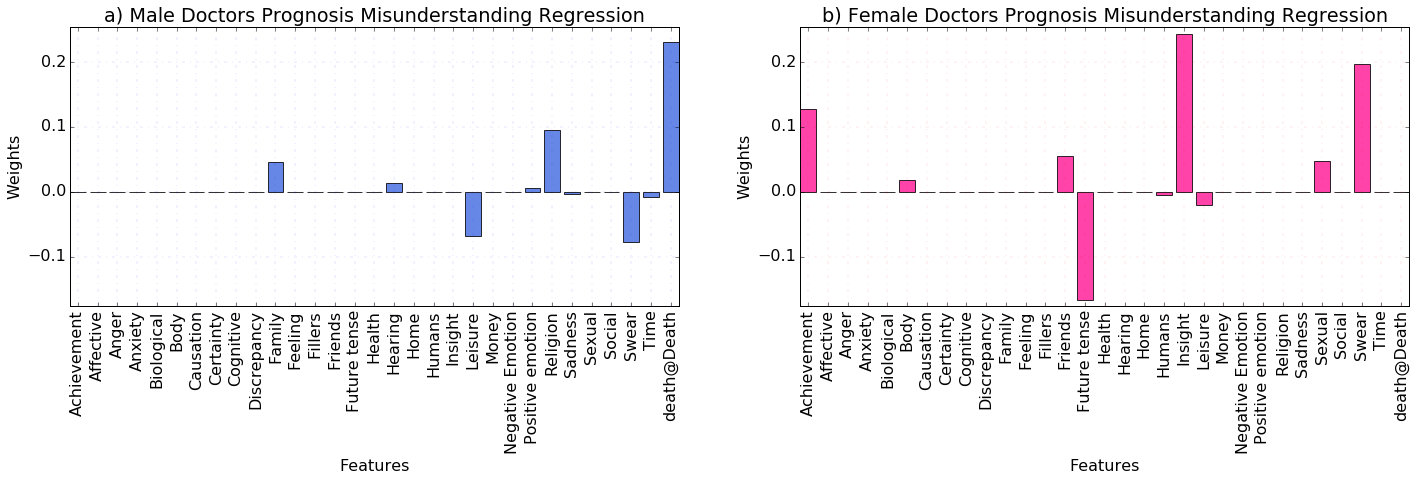

In [22]:
#print(male_Ddiscordance_coefs,female_Ddiscordance_coefs)
down = np.min(male_Ddiscordance_coefs.tolist()+female_Ddiscordance_coefs.tolist())-0.01
up = np.max(male_Ddiscordance_coefs.tolist()+female_Ddiscordance_coefs.tolist())+0.01
y_pos = np.arange(len(liwc_features))
plt.figure(figsize=(24, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.xticks(rotation=90)
plt.bar(y_pos, male_Ddiscordance_coefs, align='center', alpha=0.8,color = 'royalblue')
plt.axis('tight')
plt.ylim(down,up)
plt.xticks(y_pos, liwc_features)
plt.ylabel('Weights')
plt.xlabel('Features')
plt.title('a) Male Doctors Prognosis Misunderstanding Regression')
plt.grid(color='b', linestyle='-.', linewidth=0.1)
#plt.show()
plt.subplot(122)
plt.xticks(rotation=90)
plt.bar(y_pos, female_Ddiscordance_coefs, align='center', alpha=0.8,color = 'deeppink')
plt.axis('tight')
plt.ylim(down,up)
plt.xticks(y_pos, liwc_features)
plt.ylabel('Weights')
plt.xlabel('Features')
plt.title('b) Female Doctors Prognosis Misunderstanding Regression')
plt.grid(color='r', linestyle='-.', linewidth=0.1)
plt.savefig('male-female-doctor-discordance-regression-liwc.png',bbox_inches='tight')
plt.show()

<h2>Male-Female Doctor regression on LIWC for Cumulative Rating</h2>

In [4]:
from sklearn.linear_model import Lasso
XY = df[df['Filename'].isin(male_doctor_file_names)][['Filename']+outcome].dropna()
liwc = df_liwc[df_liwc['Filename'].isin(male_doctor_file_names)]
XY = pd.merge(XY,liwc,how='inner',on = 'Filename')
XY = XY.groupby('Filename').mean()
X = XY[liwc_features]
X = scale(X)
Y = XY['cumulative rating']
best_err = np.inf
best_alpha = 0
for a in np.arange(0.1,1,0.1):
    clf = Lasso(alpha = a).fit(X,Y)
    ans = clf.predict(X)
    err = mean_squared_error(ans,Y)
    if(err < best_err):
        best_alpha = a
        best_err = err
        male_Drating_coefs = clf.coef_
print('Best Error = ', best_err, 'alpha = ', best_alpha,male_Ddiscordance_coefs)

XY = df[df['Filename'].isin(female_doctor_file_names)][['Filename']+outcome].dropna()
liwc = df_liwc[df_liwc['Filename'].isin(female_doctor_file_names)]
XY = pd.merge(XY,liwc,how='inner',on = 'Filename')
XY = XY.groupby('Filename').mean()
X = XY[liwc_features]
X = scale(X)
Y = XY['cumulative rating']
best_err = np.inf
best_alpha = 0
for a in np.arange(0.1,1,0.1):
    clf = Lasso(alpha = a).fit(X,Y)
    ans = clf.predict(X)
    err = mean_squared_error(ans,Y)
    if(err < best_err):
        best_alpha = a
        best_err = err
        female_Drating_coefs = clf.coef_
print('Best Error = ', best_err, 'alpha = ', best_alpha,female_Ddiscordance_coefs)

Best Error =  15.346071645136343 alpha =  0.1 [-0.          0.         -0.          0.          0.          0.
  0.          0.         -0.          0.          0.04510266  0.
  0.          0.         -0.          0.          0.01360184  0.
  0.         -0.         -0.06777262  0.         -0.          0.00601478
  0.09469143 -0.00386591 -0.          0.         -0.07740009 -0.00778493
  0.23015665]
Best Error =  9.038857771751779 alpha =  0.1 [ 0.12691143 -0.          0.         -0.         -0.          0.01879359
 -0.          0.          0.         -0.          0.          0.
 -0.          0.05565788 -0.16660034 -0.          0.          0.
 -0.0048725   0.24378385 -0.02066229 -0.         -0.         -0.
 -0.          0.          0.04752872  0.          0.19662191 -0.
 -0.        ]


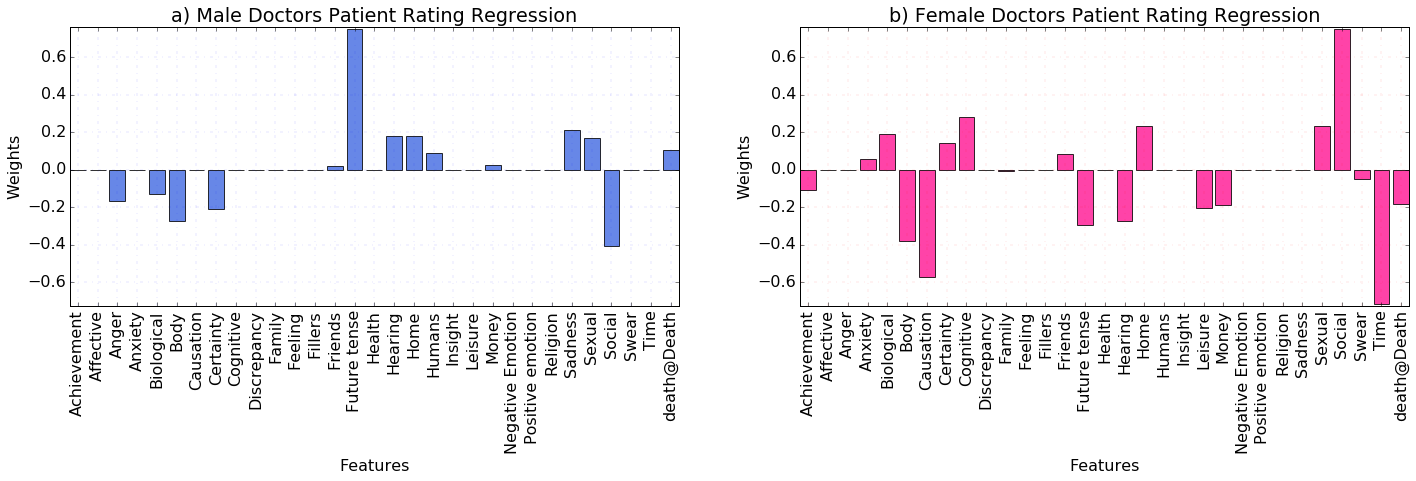

In [23]:
#print(male_Ddiscordance_coefs,female_Ddiscordance_coefs)
down = np.min(male_Drating_coefs.tolist()+female_Drating_coefs.tolist())-0.01
up = np.max(male_Drating_coefs.tolist()+female_Drating_coefs.tolist())+0.01
y_pos = np.arange(len(liwc_features))
plt.figure(figsize=(24, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.xticks(rotation=90)
plt.bar(y_pos, male_Drating_coefs, align='center', alpha=0.8,color = 'royalblue')
plt.axis('tight')
plt.ylim(down,up)
plt.xticks(y_pos, liwc_features)
plt.ylabel('Weights')
plt.xlabel('Features')
plt.title('a) Male Doctors Patient Rating Regression')
plt.grid(color='b', linestyle='-.', linewidth=0.1)
#plt.show()
plt.subplot(122)
plt.xticks(rotation=90)
plt.bar(y_pos,female_Drating_coefs, align='center', alpha=0.8,color = 'deeppink')
plt.axis('tight')
plt.ylim(down,up)
plt.xticks(y_pos, liwc_features)
plt.ylabel('Weights')
plt.xlabel('Features')
plt.title('b) Female Doctors Patient Rating Regression')
plt.grid(color='r', linestyle='-.', linewidth=0.1)
plt.savefig('male-female-doctor-rating-regression-liwc.png',bbox_inches='tight')
plt.show()

<h2>Among male doctors male-female regression on LIWC for Discordance </h2>


In [6]:
from sklearn.linear_model import Lasso
XY = df[df['Filename'].isin(maleD_maleP_file_names)][['Filename']+outcome].dropna()
liwc = df_liwc[df_liwc['Filename'].isin(maleD_maleP_file_names)]
XY = pd.merge(XY,liwc,how='inner',on = 'Filename')
XY = XY.groupby('Filename').mean()
X = XY[liwc_features]
X = scale(X)
Y = XY['discDmind3']
best_err = np.inf
best_alpha = 0
for a in np.arange(0.1,1,0.1):
    clf = Lasso(alpha = a).fit(X,Y)
    ans = clf.predict(X)
    err = mean_squared_error(ans,Y)
    if(err < best_err):
        best_alpha = a
        best_err = err
        male_Ddiscordance_coefs = clf.coef_
print('Best Error = ', best_err, 'alpha = ', best_alpha,male_Ddiscordance_coefs)

XY = df[df['Filename'].isin(maleD_femaleP_file_names)][['Filename']+outcome].dropna()
liwc = df_liwc[df_liwc['Filename'].isin(maleD_femaleP_file_names)]
XY = pd.merge(XY,liwc,how='inner',on = 'Filename')
XY = XY.groupby('Filename').mean()
X = XY[liwc_features]
X = scale(X)
Y = XY['discDmind3']
best_err = np.inf
best_alpha = 0
for a in np.arange(0.1,1,0.1):
    clf = Lasso(alpha = a).fit(X,Y)
    ans = clf.predict(X)
    err = mean_squared_error(ans,Y)
    if(err < best_err):
        best_alpha = a
        best_err = err
        female_Ddiscordance_coefs = clf.coef_
print('Best Error = ', best_err, 'alpha = ', best_alpha,female_Ddiscordance_coefs)

Best Error =  3.075105865708252 alpha =  0.1 [-0.          0.         -0.          0.0413288  -0.         -0.
  0.          0.          0.          0.          0.01369568  0.
  0.06244222  0.          0.          0.         -0.          0.
 -0.         -0.08200736  0.          0.18888831  0.          0.
  0.10747532  0.         -0.02137868  0.          0.          0.
  0.22528966]
Best Error =  2.8126167775572846 alpha =  0.1 [-0.          0.         -0.          0.          0.16430161  0.
 -0.          0.02972258 -0.          0.          0.          0.
 -0.         -0.          0.          0.14932873  0.14636757  0.
  0.07649287  0.         -0.2398253  -0.         -0.          0.23599174
  0.         -0.26081653  0.          0.         -0.27437567 -0.46980283
  0.23103617]


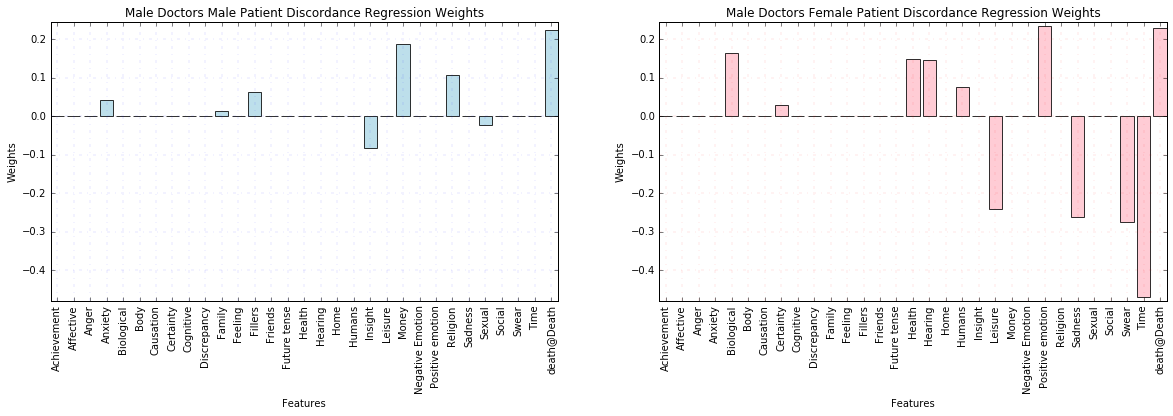

In [7]:
#print(male_Ddiscordance_coefs,female_Ddiscordance_coefs)
down = np.min(male_Ddiscordance_coefs.tolist()+female_Ddiscordance_coefs.tolist())-0.01
up = np.max(male_Ddiscordance_coefs.tolist()+female_Ddiscordance_coefs.tolist())+0.01
y_pos = np.arange(len(liwc_features))
plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.xticks(rotation=90)
plt.bar(y_pos, male_Ddiscordance_coefs, align='center', alpha=0.8,color = 'lightblue')
plt.axis('tight')
plt.ylim(down,up)
plt.xticks(y_pos, liwc_features)
plt.ylabel('Weights')
plt.xlabel('Features')
plt.title('Male Doctors Male Patient Discordance Regression Weights')
plt.grid(color='b', linestyle='-.', linewidth=0.1)
#plt.show()
plt.subplot(122)
plt.xticks(rotation=90)
plt.bar(y_pos, female_Ddiscordance_coefs, align='center', alpha=0.8,color = 'pink')
plt.axis('tight')
plt.ylim(down,up)
plt.xticks(y_pos, liwc_features)
plt.ylabel('Weights')
plt.xlabel('Features')
plt.title('Male Doctors Female Patient Discordance Regression Weights')
plt.grid(color='r', linestyle='-.', linewidth=0.1)
plt.savefig('maleD-male-female-patient-discordance-regression-liwc.png',bbox_inches='tight')
plt.show()

<h2>Among male doctors male-female regression on LIWC for Cumulative ratings </h2>

In [8]:
from sklearn.linear_model import Lasso
XY = df[df['Filename'].isin(maleD_maleP_file_names)][['Filename']+outcome].dropna()
liwc = df_liwc[df_liwc['Filename'].isin(maleD_maleP_file_names)]
XY = pd.merge(XY,liwc,how='inner',on = 'Filename')
XY = XY.groupby('Filename').mean()
X = XY[liwc_features]
X = scale(X)
Y = XY['cumulative rating']
best_err = np.inf
best_alpha = 0
for a in np.arange(0.1,1,0.1):
    clf = Lasso(alpha = a).fit(X,Y)
    ans = clf.predict(X)
    err = mean_squared_error(ans,Y)
    if(err < best_err):
        best_alpha = a
        best_err = err
        male_Ddiscordance_coefs = clf.coef_
print('Best Error = ', best_err, 'alpha = ', best_alpha,male_Ddiscordance_coefs)

XY = df[df['Filename'].isin(maleD_femaleP_file_names)][['Filename']+outcome].dropna()
liwc = df_liwc[df_liwc['Filename'].isin(maleD_femaleP_file_names)]
XY = pd.merge(XY,liwc,how='inner',on = 'Filename')
XY = XY.groupby('Filename').mean()
X = XY[liwc_features]
X = scale(X)
Y = XY['cumulative rating']
best_err = np.inf
best_alpha = 0
for a in np.arange(0.1,1,0.1):
    clf = Lasso(alpha = a).fit(X,Y)
    ans = clf.predict(X)
    err = mean_squared_error(ans,Y)
    if(err < best_err):
        best_alpha = a
        best_err = err
        female_Ddiscordance_coefs = clf.coef_
print('Best Error = ', best_err, 'alpha = ', best_alpha,female_Ddiscordance_coefs)

Best Error =  10.81008556966559 alpha =  0.1 [ 0.          0.         -0.06391557  0.         -0.         -0.31128008
 -0.         -0.39675886 -0.          0.03515004 -0.          0.
  0.          0.07681544  1.00977678  0.08078413  0.68398716  0.13356414
  0.         -0.22941432  0.         -0.01062499 -0.          0.01446828
  0.17641853  0.50421895  0.01465662 -0.45568689 -0.         -0.19501546
 -0.        ]
Best Error =  18.07146638321878 alpha =  0.1 [-0.00000000e+00 -0.00000000e+00 -2.23122369e-01  2.09296323e-01
 -0.00000000e+00 -1.16577882e-01  1.68110754e-01 -4.89711531e-04
 -0.00000000e+00 -1.30494496e-01  3.06114087e-01 -0.00000000e+00
 -2.71876856e-01  5.66302007e-02  6.21694930e-01 -5.66716862e-01
  1.09936976e-02  2.28849723e-01  0.00000000e+00  1.85014075e-01
 -1.55310458e-01  3.62227705e-01  3.96282215e-02 -0.00000000e+00
 -1.26992388e-01 -0.00000000e+00  1.23561580e-01 -9.65652511e-01
  1.59552545e-01  7.22111944e-01  1.15798806e-01]


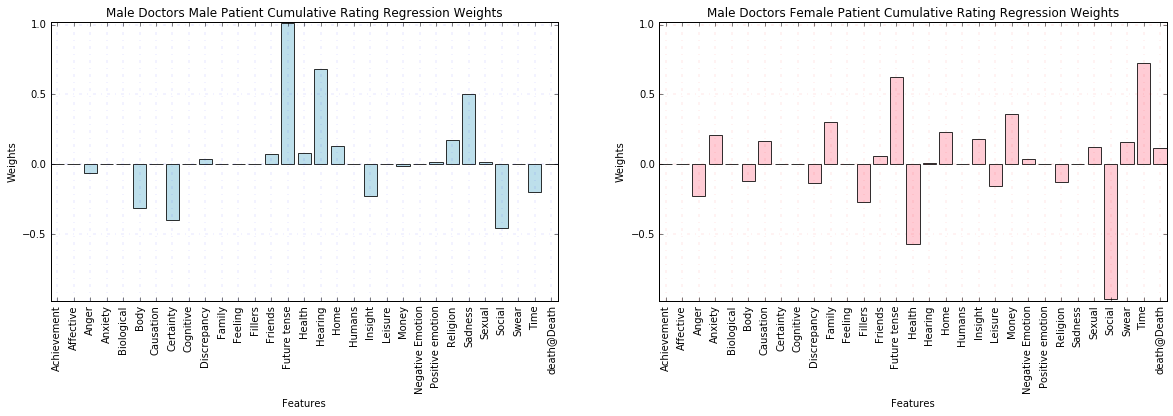

In [9]:
#print(male_Ddiscordance_coefs,female_Ddiscordance_coefs)
down = np.min(male_Ddiscordance_coefs.tolist()+female_Ddiscordance_coefs.tolist())-0.01
up = np.max(male_Ddiscordance_coefs.tolist()+female_Ddiscordance_coefs.tolist())+0.01
y_pos = np.arange(len(liwc_features))
plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.xticks(rotation=90)
plt.bar(y_pos, male_Ddiscordance_coefs, align='center', alpha=0.8,color = 'lightblue')
plt.axis('tight')
plt.ylim(down,up)
plt.xticks(y_pos, liwc_features)
plt.ylabel('Weights')
plt.xlabel('Features')
plt.title('Male Doctors Male Patient Cumulative Rating Regression Weights')
plt.grid(color='b', linestyle='-.', linewidth=0.1)
#plt.show()
plt.subplot(122)
plt.xticks(rotation=90)
plt.bar(y_pos, female_Ddiscordance_coefs, align='center', alpha=0.8,color = 'pink')
plt.axis('tight')
plt.ylim(down,up)
plt.xticks(y_pos, liwc_features)
plt.ylabel('Weights')
plt.xlabel('Features')
plt.title('Male Doctors Female Patient Cumulative Rating Regression Weights')
plt.grid(color='r', linestyle='-.', linewidth=0.1)
plt.savefig('maleD-male-female-patient-rating-regression-liwc.png',bbox_inches='tight')
plt.show()

<h2>Among female doctors male-female regression on LIWC for Discordance ratings</h2>

In [10]:
from sklearn.linear_model import Lasso
XY = df[df['Filename'].isin(femaleD_maleP_file_names)][['Filename']+outcome].dropna()
liwc = df_liwc[df_liwc['Filename'].isin(femaleD_maleP_file_names)]
XY = pd.merge(XY,liwc,how='inner',on = 'Filename')
XY = XY.groupby('Filename').mean()
X = XY[liwc_features]
X = scale(X)
Y = XY['discDmind3']
best_err = np.inf
best_alpha = 0
for a in np.arange(0.1,1,0.1):
    clf = Lasso(alpha = a).fit(X,Y)
    ans = clf.predict(X)
    err = mean_squared_error(ans,Y)
    if(err < best_err):
        best_alpha = a
        best_err = err
        male_Ddiscordance_coefs = clf.coef_
print('Best Error = ', best_err, 'alpha = ', best_alpha,male_Ddiscordance_coefs)

XY = df[df['Filename'].isin(femaleD_femaleP_file_names)][['Filename']+outcome].dropna()
liwc = df_liwc[df_liwc['Filename'].isin(femaleD_femaleP_file_names)]
XY = pd.merge(XY,liwc,how='inner',on = 'Filename')
XY = XY.groupby('Filename').mean()
X = XY[liwc_features]
X = scale(X)
Y = XY['discDmind3']
best_err = np.inf
best_alpha = 0
for a in np.arange(0.1,1,0.1):
    clf = Lasso(alpha = a).fit(X,Y)
    ans = clf.predict(X)
    err = mean_squared_error(ans,Y)
    if(err < best_err):
        best_alpha = a
        best_err = err
        female_Ddiscordance_coefs = clf.coef_
print('Best Error = ', best_err, 'alpha = ', best_alpha,female_Ddiscordance_coefs)

Best Error =  1.4967343413477414 alpha =  0.1 [ 0.20783292 -0.          0.         -0.49361711 -0.         -0.
  0.22410532 -0.02138912 -0.         -0.1491584   0.          0.08957352
  0.          0.         -0.01187429  0.          0.          0.69916999
 -0.          0.70460126 -0.11564005 -0.         -0.72441053 -0.
  0.          0.25193642  0.34616462  0.          0.          0.
  0.35158195]
Best Error =  2.232201065403072 alpha =  0.1 [ 0.          0.         -0.          0.13249796 -0.          0.
 -0.08152975  0.10723235  0.          0.          0.         -0.
 -0.05099084  0.0187161  -0.          0.         -0.         -0.12814577
 -0.09984457  0.26233746  0.         -0.          0.          0.
  0.          0.         -0.          0.12361058  0.31544873 -0.35976466
 -0.18776145]


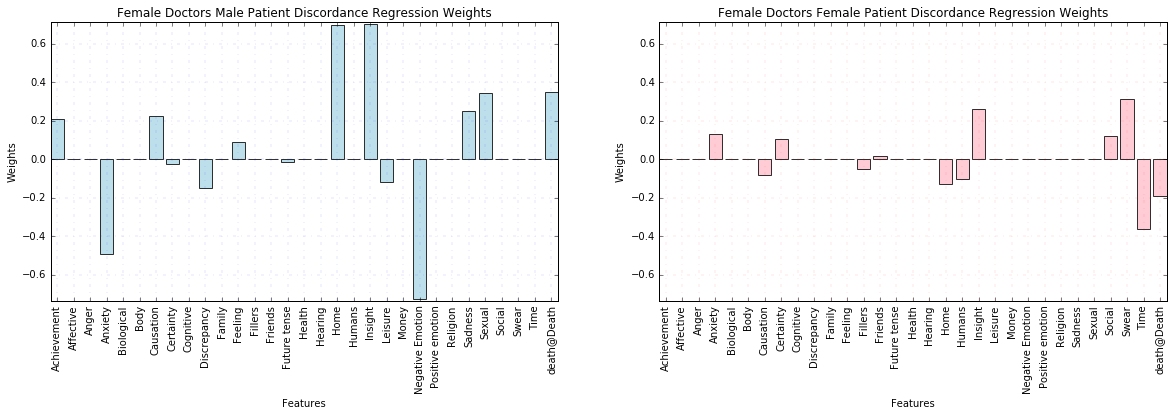

In [11]:
#print(male_Ddiscordance_coefs,female_Ddiscordance_coefs)
down = np.min(male_Ddiscordance_coefs.tolist()+female_Ddiscordance_coefs.tolist())-0.01
up = np.max(male_Ddiscordance_coefs.tolist()+female_Ddiscordance_coefs.tolist())+0.01
y_pos = np.arange(len(liwc_features))
plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.xticks(rotation=90)
plt.bar(y_pos, male_Ddiscordance_coefs, align='center', alpha=0.8,color = 'lightblue')
plt.axis('tight')
plt.ylim(down,up)
plt.xticks(y_pos, liwc_features)
plt.ylabel('Weights')
plt.xlabel('Features')
plt.title('Female Doctors Male Patient Discordance Regression Weights')
plt.grid(color='b', linestyle='-.', linewidth=0.1)
#plt.show()
plt.subplot(122)
plt.xticks(rotation=90)
plt.bar(y_pos, female_Ddiscordance_coefs, align='center', alpha=0.8,color = 'pink')
plt.axis('tight')
plt.ylim(down,up)
plt.xticks(y_pos, liwc_features)
plt.ylabel('Weights')
plt.xlabel('Features')
plt.title('Female Doctors Female Patient Discordance Regression Weights')
plt.grid(color='r', linestyle='-.', linewidth=0.1)
plt.savefig('femaleD-male-female-patient-discordance-regression-liwc.png',bbox_inches='tight')
plt.show()

<h2>Among female doctors male-female regression on LIWC for Cumulative ratings </h2>


In [12]:
from sklearn.linear_model import Lasso
XY = df[df['Filename'].isin(femaleD_maleP_file_names)][['Filename']+outcome].dropna()
liwc = df_liwc[df_liwc['Filename'].isin(femaleD_maleP_file_names)]
XY = pd.merge(XY,liwc,how='inner',on = 'Filename')
XY = XY.groupby('Filename').mean()
X = XY[liwc_features]
X = scale(X)
Y = XY['cumulative rating']
best_err = np.inf
best_alpha = 0
for a in np.arange(0.1,1,0.1):
    clf = Lasso(alpha = a).fit(X,Y)
    ans = clf.predict(X)
    err = mean_squared_error(ans,Y)
    if(err < best_err):
        best_alpha = a
        best_err = err
        male_Ddiscordance_coefs = clf.coef_
print('Best Error = ', best_err, 'alpha = ', best_alpha,male_Ddiscordance_coefs)

XY = df[df['Filename'].isin(femaleD_femaleP_file_names)][['Filename']+outcome].dropna()
liwc = df_liwc[df_liwc['Filename'].isin(femaleD_femaleP_file_names)]
XY = pd.merge(XY,liwc,how='inner',on = 'Filename')
XY = XY.groupby('Filename').mean()
X = XY[liwc_features]
X = scale(X)
Y = XY['cumulative rating']
best_err = np.inf
best_alpha = 0
for a in np.arange(0.1,1,0.1):
    clf = Lasso(alpha = a).fit(X,Y)
    ans = clf.predict(X)
    err = mean_squared_error(ans,Y)
    if(err < best_err):
        best_alpha = a
        best_err = err
        female_Ddiscordance_coefs = clf.coef_
print('Best Error = ', best_err, 'alpha = ', best_alpha,female_Ddiscordance_coefs)

Best Error =  2.5217485851745627 alpha =  0.1 [-0.         -0.74632251  1.18074877  0.57136904  0.          1.01761476
 -0.          0.74844722 -0.         -0.8279152  -1.73908305 -0.3323082
 -0.04862033  0.24544312  1.3158615  -0.30242142 -0.5117021  -0.
  0.67144309 -1.13581327 -0.13689834 -0.17739908 -0.         -0.
 -0.80729199 -0.27848184 -1.17960281 -0.          0.         -0.23014083
  0.        ]
Best Error =  6.5123536772704025 alpha =  0.1 [-0.60511669  0.         -0.26946267 -0.          0.2650688  -0.84178183
 -0.73773842  0.          1.64549986  0.         -0.          0.
  0.12213446 -0.03564079 -1.56394234  0.15080455 -0.39575388  0.12552849
 -0.20162759  0.          0.         -0.          0.          0.
 -0.          0.35498072  0.67808101  0.49817985 -0.10263152 -0.37606722
  0.        ]


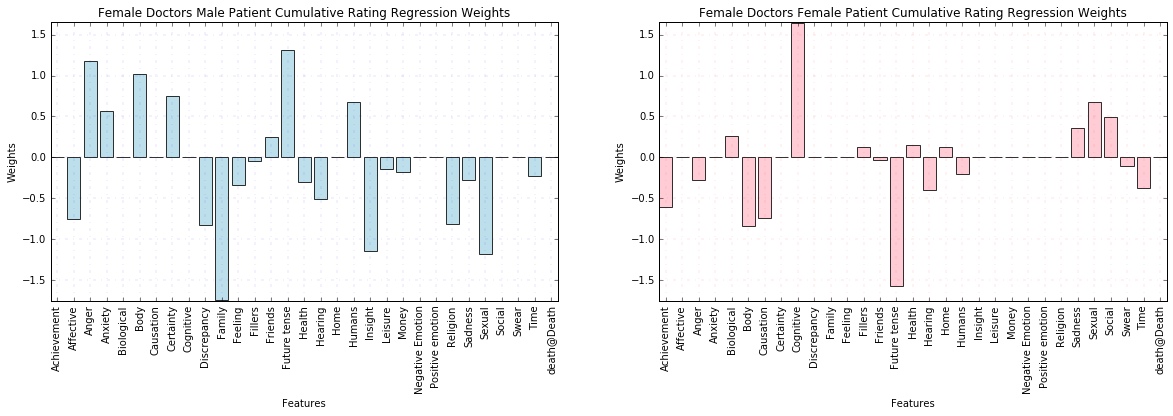

In [13]:
#print(male_Ddiscordance_coefs,female_Ddiscordance_coefs)
down = np.min(male_Ddiscordance_coefs.tolist()+female_Ddiscordance_coefs.tolist())-0.01
up = np.max(male_Ddiscordance_coefs.tolist()+female_Ddiscordance_coefs.tolist())+0.01
y_pos = np.arange(len(liwc_features))
plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.xticks(rotation=90)
plt.bar(y_pos, male_Ddiscordance_coefs, align='center', alpha=0.8,color = 'lightblue')
plt.axis('tight')
plt.ylim(down,up)
plt.xticks(y_pos, liwc_features)
plt.ylabel('Weights')
plt.xlabel('Features')
plt.title('Female Doctors Male Patient Cumulative Rating Regression Weights')
plt.grid(color='b', linestyle='-.', linewidth=0.1)
#plt.show()
plt.subplot(122)
plt.xticks(rotation=90)
plt.bar(y_pos, female_Ddiscordance_coefs, align='center', alpha=0.8,color = 'pink')
plt.axis('tight')
plt.ylim(down,up)
plt.xticks(y_pos, liwc_features)
plt.ylabel('Weights')
plt.xlabel('Features')
plt.title('Female Doctors Female Patient Cumulative Rating Regression Weights')
plt.grid(color='r', linestyle='-.', linewidth=0.1)
plt.savefig('femaleD-male-female-patient-rating-regression-liwc.png',bbox_inches='tight')
plt.show()